In [154]:
import pandas as pd
import numpy as np 
from pulp import *
import matplotlib.pyplot as plt
import seaborn as sns

Question 15.2

In the videos, we saw the “diet problem”. (The diet problem is one of the first large-scale optimization
problems to be studied in practice. Back in the 1930’s and 40’s, the Army wanted to meet the nutritional
requirements of its soldiers while minimizing the cost.) In this homework you get to solve a diet problem with real data. The data is given in the file diet.xls. 

1.	Formulate an optimization model (a linear program) to find the cheapest diet that satisfies the maximum and minimum daily nutrition constraints, and solve it using PuLP.  Turn in your code and the solution. (The optimal solution should be a diet of air-popped popcorn, poached eggs, oranges, raw iceberg lettuce, raw celery, and frozen broccoli. UGH!)
2.	Please add to your model the following constraints (which might require adding more variables) and solve the new model:
a.	If a food is selected, then a minimum of 1/10 serving must be chosen. (Hint: now you will need two variables for each food i: whether it is chosen, and how much is part of the diet. You’ll also need to write a constraint to link them.)
b.	Many people dislike celery and frozen broccoli. So at most one, but not both, can be selected.
c.	To get day-to-day variety in protein, at least 3 kinds of meat/poultry/fish/eggs must be selected. [If something is ambiguous (e.g., should bean-and-bacon soup be considered meat?), just call it whatever you think is appropriate – I want you to learn how to write this type of constraint, but I don’t really care whether we agree on how to classify foods!]

If you want to see what a more full-sized problem would look like, try solving your models for the file diet_large.xls, which is a low-cholesterol diet model (rather than minimizing cost, the goal is to minimize cholesterol intake).  I don’t know anyone who’d want to eat this diet – the optimal solution includes dried chrysanthemum garland, raw beluga whale flipper, freeze-dried parsley, etc. – which shows why it’s necessary to add additional constraints beyond the basic ones we saw in the video!
	[Note: there are many optimal solutions, all with zero cholesterol, so you might get a different one.  It probably won’t be much more appetizing than mine.]



In [139]:
df = pd.read_excel("diet.xls", header = 0) # read all data

In [140]:
df.head()

,Foods,Price/ Serving,Serving Size,Calories,Cholesterol mg,Total_Fat g,Sodium mg,Carbohydrates g,Dietary_Fiber g,Protein g,Vit_A IU,Vit_C IU,Calcium mg,Iron mg
0,Frozen Broccoli,0.16,10 Oz Pkg,73.8,0.0,0.8,68.2,13.6,8.5,8.0,5867.4,160.2,159.0,2.3
1,"Carrots,Raw",0.07,1/2 Cup Shredded,23.7,0.0,0.1,19.2,5.6,1.6,0.6,15471.0,5.1,14.9,0.3
2,"Celery, Raw",0.04,1 Stalk,6.4,0.0,0.1,34.8,1.5,0.7,0.3,53.6,2.8,16.0,0.2
3,Frozen Corn,0.18,1/2 Cup,72.2,0.0,0.6,2.5,17.1,2.0,2.5,106.6,5.2,3.3,0.3
4,"Lettuce,Iceberg,Raw",0.02,1 Leaf,2.6,0.0,0.0,1.8,0.4,0.3,0.2,66.0,0.8,3.8,0.1


In [152]:
data = df[0:64]

# convert to list "list within a list"
data = data.values.tolist()

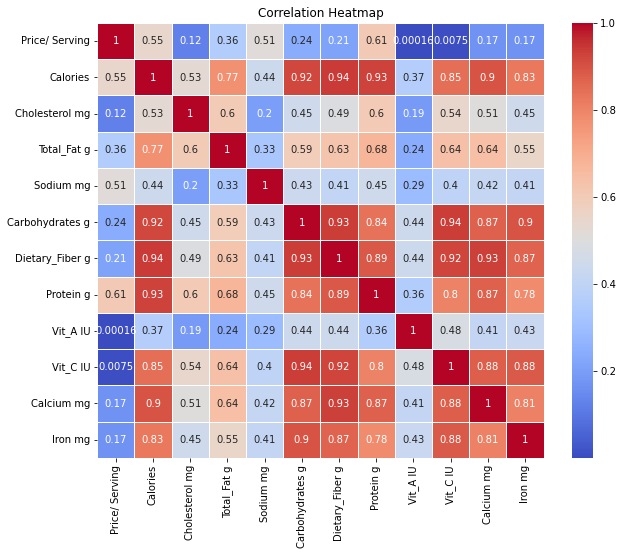

In [155]:
# Running a correlation matrix for fun
correlation_matrix = df.corr()

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()



The provided code processes a list of data containing nutritional information for various foods. It creates dictionaries for different nutrients, such as calories, cholesterol, total fat, sodium, carbohydrates, fiber, protein, and more. Each dictionary maps the food name to its corresponding nutrient value, making it easy to access and analyze nutritional data for different foods. This code is a convenient way to organize and work with food-related information. After, I create the minimum and maximum values and store them in a list.



In [142]:
diet = [x[0] for x in data]
calories = dict([(x[0], float(x[3])) for x in data])
cholesterol = dict([(x[0], float(x[4])) for x in data])
totalFat = dict([(x[0], float(x[5])) for x in data])
sodium = dict([(x[0], float(x[6])) for x in data])
carbs = dict([(x[0], float(x[7])) for x in data])
fiber = dict([(x[0], float(x[8])) for x in data])
protien = dict([(x[0], float(x[9])) for x in data])
vitaminA = dict([(x[0], float(x[10])) for x in data])
vitaminC = dict([(x[0], float(x[11])) for x in data])
calcium = dict([(x[0], float(x[12])) for x in data])
iron = dict([(x[0], float(x[13])) for x in data])

In [143]:
amin = [1500, 30, 20, 800, 130, 125, 60, 1000, 400, 700, 10] 
amax = [2500, 240, 70, 2000, 450, 250, 100, 10000, 5000, 1500, 40]

First, I identified the indices for different nutrients within the sub-lists, from 3 to 13, considering the first two elements as the food name and its cost. Using a list comprehension, I created the list B, which contains dictionaries for each nutrient. In each dictionary, I extracted the food name and the corresponding nutrient value, converting it to a float. This resulted in a list of dictionaries, one for each nutrient, simplifying the access to nutritional data. Furthermore, I established a separate cost dictionary. In this case, I directly organized food costs using a dictionary comprehension, utilizing the food name as the key and the converted cost as the value. This structure facilitates quick access to food cost information.

This code makes it efficient and convenient to work with both nutritional and cost data for diverse foods.

In [144]:
# Create the list of dictionaries for nutrients
B = [dict((x[0], float(x[j + 3])) for x in data) for j in range(11)]

# Create the dictionary for food costs
cost = {x[0]: float(x[1]) for x in data}


I'm creating a linear programming problem named 'diet' with the goal of minimizing some objective function. I'm also defining decision variables for food items. The 'foodVars' variable represents the quantity of each food, while 'chosenVars' is binary, indicating whether a food is chosen (1) or not (0). These variables will likely be used to optimize a diet based on certain criteria, but the specific criteria and constraints are not shown here.

In [145]:
prob = LpProblem('diet', LpMinimize)

foodVars = LpVariable.dicts("foods", foods,0)

chosenVars = LpVariable.dicts("Chosen",diet,0,1,"Binary") 

x = LpVariable.dicts("x", diet, 0) 

In [146]:
# Define the objective function
prob += pulp.lpSum(cost[f] * foodVars[f] for f in diet)

# Set constraints for foodVars based on chosenVars
for f in diet:
    prob += foodVars[f] <= 10000 * chosenVars[f]
    prob += foodVars[f] >= 0.1 * chosenVars[f]

# Nutrient constraints
for i in range(11):
    B_x = pulp.lpSum(B[i][j] * foodVars[j] for j in diet)
    prob += amin[i] <= B_x
    prob += amax[i] >= B_x

# At most one Broccoli / Celery
at_most_one_broccoli_celery = ['Frozen Broccoli', 'Celery, Raw']
prob += pulp.lpSum(chosenVars[food] for food in at_most_one_broccoli_celery) <= 1, 'At most one Broccoli / Celery'

# At least three proteins
protein_foods = ['Roasted Chicken', 'Poached Eggs', 'Scrambled Eggs', 'Frankfurter, Beef', 'Kielbasa,Prk', 'Hamburger W/Toppings', 'Hotdog, Plain', 'Pork', 'Bologna,Turkey', 'Ham,Sliced,Extralean', 'White Tuna in Water']
prob += pulp.lpSum(chosenVars[food] for food in protein_foods) >= 3, 'At least three proteins'


 I first define the objective function to minimize the total cost of food items. Then, I set constraints for the food items based on whether they are chosen or not. I ensure that chosen foods have quantities between 0.1 and 10,000 units. Next, I specify nutrient constraints for the diet, making sure it meets the minimum and maximum nutrient requirements. Additionally, I set constraints to allow at most one choice between 'Frozen Broccoli' and 'Celery, Raw' and require at least three food items from a list of protein sources. This code helps me find an optimal diet that meets nutritional needs while minimizing the cost.






In [135]:
# Solve the optimization problem
prob.solve()



Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/zubairlakhia/opt/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/n1/lv8fns85015dwwtk_bwm8k600000gn/T/a1835e189f4f420491e2d7bb6da3bf4e-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/n1/lv8fns85015dwwtk_bwm8k600000gn/T/a1835e189f4f420491e2d7bb6da3bf4e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 157 COLUMNS
At line 1813 RHS
At line 1966 BOUNDS
At line 2031 ENDATA
Problem MODEL has 152 rows, 128 columns and 1463 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 4.38006 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 64 strengthened rows, 0 substitutions
Cgl0004I processed model has 141 rows, 128 columns (64 integer (64 of which binary)) and 866 elements
Cbc0038I Initial state - 8 integers unsatisfied sum - 1.63213
Cbc003

1

minf.    0.44942 (2) obj. 4.50011 iterations 21
Cbc0038I Pass  11: suminf.    0.17842 (2) obj. 4.50011 iterations 1
Cbc0038I Pass  12: suminf.    0.66106 (5) obj. 4.50011 iterations 24
Cbc0038I Pass  13: suminf.    0.18928 (2) obj. 4.50011 iterations 18
Cbc0038I Pass  14: suminf.    0.30513 (2) obj. 4.50011 iterations 15
Cbc0038I Pass  15: suminf.    1.00048 (5) obj. 4.50011 iterations 15
Cbc0038I Pass  16: suminf.    0.62073 (4) obj. 4.50011 iterations 6
Cbc0038I Pass  17: suminf.    0.28172 (2) obj. 4.50011 iterations 7
Cbc0038I Pass  18: suminf.    0.20105 (2) obj. 4.50011 iterations 2
Cbc0038I Pass  19: suminf.    0.46919 (3) obj. 4.50011 iterations 12
Cbc0038I Pass  20: suminf.    0.46919 (3) obj. 4.50011 iterations 6
Cbc0038I Pass  21: suminf.    0.33208 (2) obj. 4.50011 iterations 15
Cbc0038I Pass  22: suminf.    0.17925 (2) obj. 4.50011 iterations 2
Cbc0038I Pass  23: suminf.    0.22348 (3) obj. 4.50011 iterations 11
Cbc0038I Pass  24: suminf.    0.21736 (2) obj. 4.50011 iterat

In [134]:
print("Total cost of diet = $%.2f" % value(prob.objective)) 

Total cost of diet = $4.51


The outcome minimizes the cost to $4.51 while satisfying the necessary constraints.